In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import DataGen
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
%matplotlib inline
np.random.seed(42)
tf.set_random_seed(42)
# use cpu
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

 # Load model

In [1]:
model_weights = 'Conv3D-weights.h5'

In [4]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization, SpatialDropout3D
from keras.models import Model
def Conv3D_model(input_shape = (182, 218, 182, 1)):
    input_layer = Input(input_shape)
    prev_layer = input_layer
    for i in range(4):
        layer = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(prev_layer)
        layer = Activation('relu')(layer)
        layer = MaxPool3D(pool_size=(2, 2, 2))(layer)
        layer = BatchNormalization()(layer)
        prev_layer = layer
    
    flatten_layer = Flatten()(prev_layer)
    age_layer = Dense(units=1, activation='linear' , name='age')(flatten_layer)
    sex_layer = Dense(units=1, activation='sigmoid', name='sex')(flatten_layer)
    
    return Model(inputs=input_layer, outputs=[age_layer, sex_layer])

model = Conv3D_model()
model.load_weights(model_weights)

# Evaluate

In [101]:
from sklearn.metrics import accuracy_score, mean_absolute_error
def evaluate(Datagen):
    Datagen.init()
    age, sex = (Datagen.age, Datagen.sex)
    age_hat, sex_hat = model.predict_generator(Datagen(), steps=Datagen.total_samples)
    age_hat, sex_hat = (age_hat.flatten()[age!=-1], sex_hat.flatten()[sex!=-1])
    age, sex = (age[age!=-1], sex[sex!=-1])
    return age, age_hat, sex, sex_hat
def print_metrics(results):
    age, age_hat, sex, sex_hat = results
    mae = mean_absolute_error(age, age_hat) if age.size > 0 else "Not available"
    acc = accuracy_score(sex,sex_hat > .5) if sex.size > 0 else "Not available"
    print("Age MAE:", mae)
    print("Sex accuracy:", acc)

In [255]:
def scatter_age(results, ax=None, by_sex=False):
    fig = None
    if ax is None:
        fig, ax = plt.subplots()
    age, age_hat, sex, sex_hat = results
    minimum = 0
    maximum = 100
    ax.plot([minimum, maximum], [minimum, maximum],'--')
    ax.set_xlim(minimum, maximum)
    ax.set_ylim(minimum, maximum)
    ax.set_xlabel('True age (years)', fontsize=12)
    ax.set_ylabel('Predicted age (years)', fontsize=12)
    mae = str(round(mean_absolute_error(age, age_hat), 2))+' years' if age.size > 0 else "Not available"
    ax.text(.03, .9, 'N = '+str(len(age)), fontsize=16, ha='left', transform = ax.transAxes)
    ax.text(.03, .8, 'MAE = '+mae, fontsize=16, ha='left', transform = ax.transAxes)
    if age.size == 0:
        return fig, ax
    
    if by_sex:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        sm = ax.scatter(age[sex==0], age_hat[sex==0], s=40, c=colors[0])
        sf = ax.scatter(age[sex==1], age_hat[sex==1], s=40, c=colors[1])
        mmae = str(round(mean_absolute_error(age[sex==0], age_hat[sex==0]), 2))
        fmae = str(round(mean_absolute_error(age[sex==1], age_hat[sex==1]), 2))
        ax.legend([sm, sf], ['Male: MAE = '+mmae, 'Female: MAE = '+fmae], fontsize=14, loc='lower right', markerfirst=False, handletextpad=0.1)
    else:
        ax.scatter(age, age_hat, s=40)
    
    return fig, ax

In [225]:
def stem_sex(results, ax=None):
    fig = False
    if ax is None:
        fig, ax = plt.subplots()
    age, age_hat, sex, sex_hat = results
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    males = np.copy(sex_hat[sex==0])
    females = np.copy(sex_hat[sex==1])
    if len(males)>0:
        males = 1-males
        males.sort(axis=0)
        markerline, stemlines, baseline = ax.stem(males, bottom = 0.5)
        plt.setp(stemlines, color=colors[0], linewidth=2)
        plt.setp(markerline, color=colors[0], linewidth=2)
        plt.setp(baseline, color='r', linewidth=6)
        if (len(females)>0):
            ax.text(.3, .25, 'Males', fontsize=14, ha='center', transform = ax.transAxes)
            ax.text(.3, .19, str(round(100*np.sum(males>.5)/males.size,2))+'%', fontsize=14, ha='center', transform = ax.transAxes)
    
    if len(females)>0:
        females.sort(axis=0)
        females = females[::-1]
        f_idx = np.arange(len(males),len(males)+len(females))+1
        markerline, stemlines, baseline = ax.stem(f_idx, females, bottom = 0.5)
        plt.setp(stemlines, color=colors[1], linewidth=2)
        plt.setp(markerline, color=colors[1])
        plt.setp(baseline, color='r', linewidth=6)
        if len(males)>0:
            ax.text(.7, .25, 'Females', fontsize=14, ha='center', transform = ax.transAxes)
            ax.text(.7, .19, str(round(100*np.sum(females>.5)/females.size,2))+'%', fontsize=14, ha='center', transform = ax.transAxes)
    ax.text(.5, .37, 'Accuracy: '+str(round(100*accuracy_score(sex,sex_hat>.5),2))+'%', fontsize=16, ha='center', transform = ax.transAxes)
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel('Correct prediction certainty', fontsize=12)
    ax.set_xticks([])
    
    if fig:
        return fig, ax

In [108]:
def plot_results(results):
    rc = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [12,4]
    for i in results:
        print(i)
        print_metrics(results[i])
        fig, ax = plt.subplots(1,2)
        scatter_age(results[i], ax[0])
        stem_sex(results[i], ax[1])
        plt.show()
        print()
    plt.rcParams['figure.figsize'] = rc
    return fig, ax

In [8]:
datasets = {
    'IXI_train':      DataGen('IXI_train.csv', './data'),
    'IXI_val':        DataGen('IXI_val.csv', './data'),
    'IXI_test':       DataGen('IXI_test.csv', './data'),
    'OASIS_train':    DataGen('OASIS3_train.csv', './data'),
    'OASIS_val':      DataGen('OASIS3_val.csv', './data'),
    'OASIS_test':     DataGen('OASIS3_test.csv', './data'),
    'openfmri_train': DataGen('openfmri_train.csv', './data'),
    'openfmri_val':   DataGen('openfmri_val.csv', './data'),
    'openfmri_test':  DataGen('openfmri_test.csv', './data')
}

In [9]:
import pickle

# results = {}
# for i in datasets:
#     print(i)
#     results[i] = evaluate(datasets[i])
# with open('results_final.pickle', 'wb') as file:
#     pickle.dump(results, file)
    
with open('results_final.pickle', 'rb') as file:
    results = pickle.load(file) 
    
# merge results to train,validation and test set
results['train'] = []
results['test'] = []
results['val'] = []
for i in range(4):
    results['train'].append(np.concatenate([results['IXI_train'][i], results['OASIS_train'][i], results['openfmri_train'][i]]))
    results['val'].append(np.concatenate([results['IXI_val'][i], results['OASIS_val'][i], results['openfmri_val'][i]]))
    results['test'].append(np.concatenate([results['IXI_test'][i], results['OASIS_test'][i], results['openfmri_test'][i]]))

IXI_train
Age MAE: 5.834673533243109
Sex accuracy: 0.9783080260303688


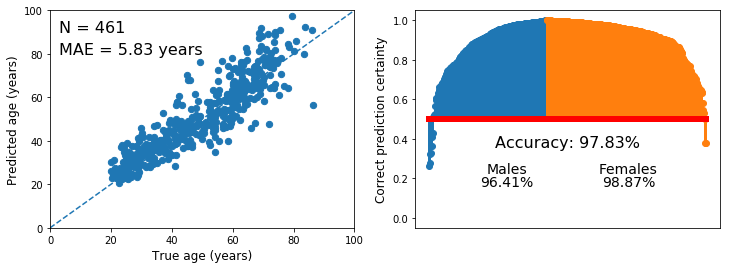


IXI_val
Age MAE: 7.161507275390624
Sex accuracy: 0.94


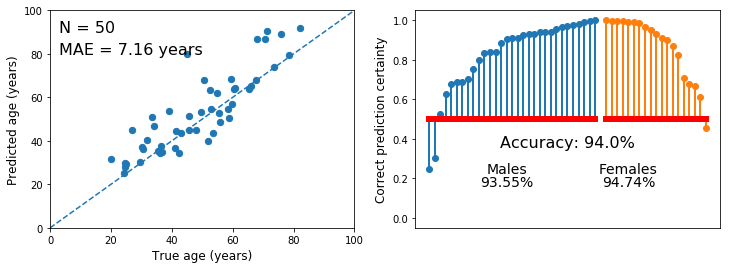


IXI_test
Age MAE: 6.132186457824707
Sex accuracy: 1.0


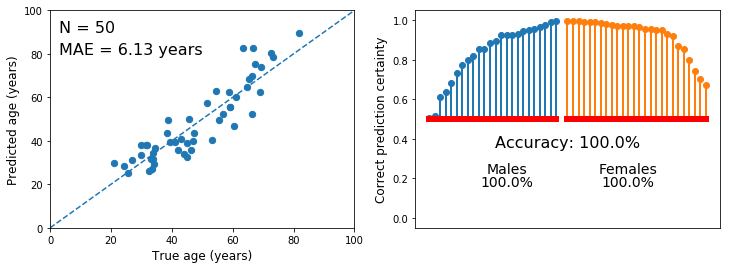


OASIS_train
Age MAE: Not available
Sex accuracy: 0.9934354485776805


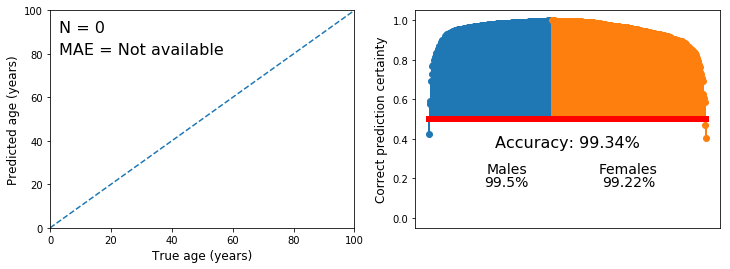


OASIS_val
Age MAE: Not available
Sex accuracy: 0.98


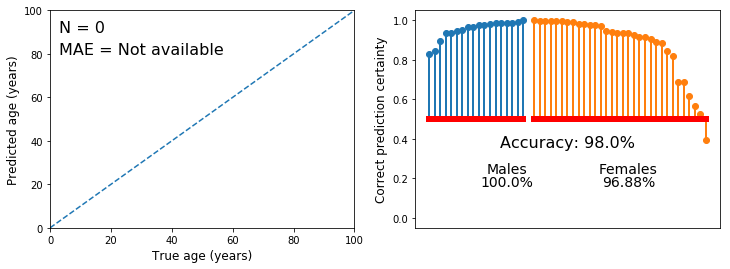


OASIS_test
Age MAE: Not available
Sex accuracy: 0.9


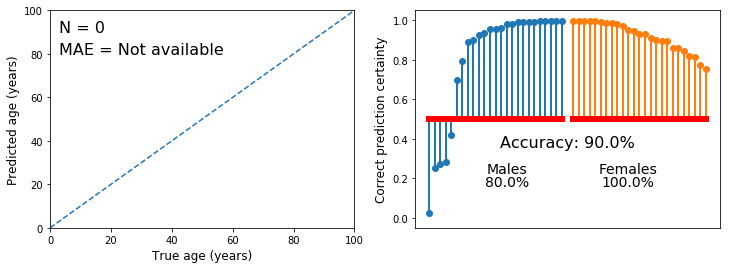


openfmri_train
Age MAE: 3.795482237636897
Sex accuracy: 0.9707887049659202


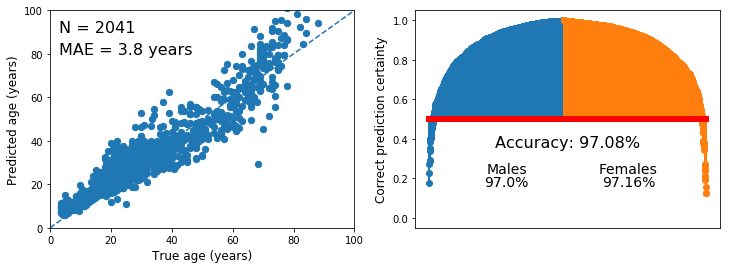


openfmri_val
Age MAE: 3.9562854715720897
Sex accuracy: 0.9175257731958762


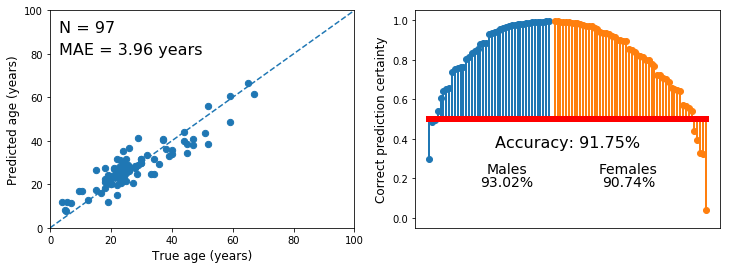


openfmri_test
Age MAE: 4.198347536087036
Sex accuracy: 0.88


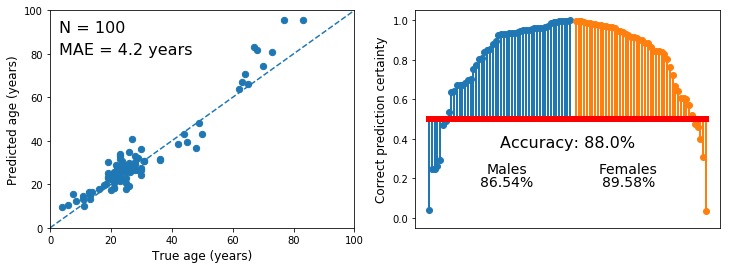


train
Age MAE: 4.171208531511582
Sex accuracy: 0.9754374158815612


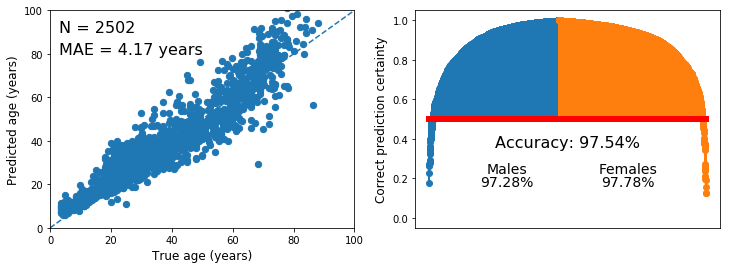


test
Age MAE: 4.842960509999593
Sex accuracy: 0.915


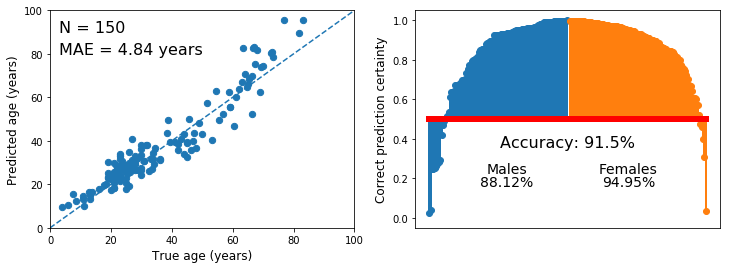


val
Age MAE: 5.04649696946955
Sex accuracy: 0.9390862944162437


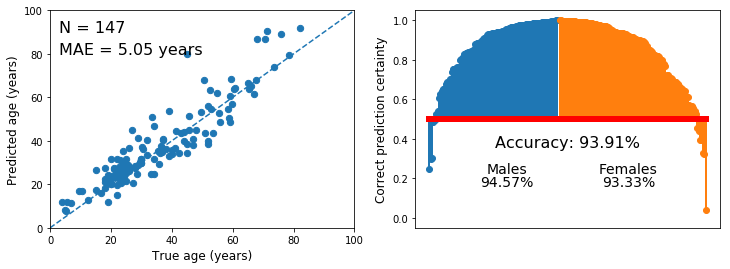

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4cc0f3fd0>,
       dtype=object))

In [217]:
plot_results(results)

## Results

In [12]:
age, age_hat, sex, sex_hat = results['test']
mens_pred = sex_hat[sex==0]<.5
fems_pred = sex_hat[sex==1]>=.5
print('Males: Correct', np.sum(mens_pred), 'incorrect',np.sum(mens_pred==False))
print('Females: Correct', np.sum(fems_pred), 'incorrect',np.sum(fems_pred==False))

Males: Correct 89 incorrect 12
Females: Correct 94 incorrect 5


Age MAE: 4.842960509999593
Sex accuracy: 0.915


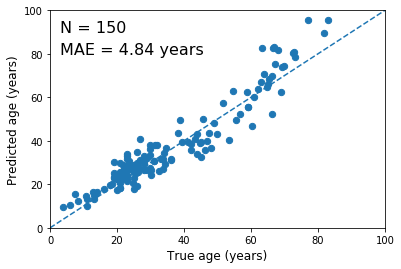

In [34]:
print_metrics(results['test'])
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = scatter_age(results['test'])
fig.savefig('scatter_age_test.png')

## Subsets

In [54]:
# test = DataGen('test.csv', './data')
# age, sex = (test.age, test.sex)
# age_hat, sex_hat = model.predict_generator(test(), steps=test.total_samples)
# with open('results_test_set.pickle', 'wb') as file:
#     pickle.dump((age, age_hat, sex, sex_hat), file)

with open('results_test_set.pickle', 'rb') as file:
    (age, age_hat, sex, sex_hat) = pickle.load(file)

In [111]:
u40idx = np.logical_and(age<40, age != -1)
o40idx = np.logical_and(age>40, age != -1)
age_u40 = age[u40idx]
age_o40 = age[o40idx]
age_hat_u40 = age_hat[u40idx]
age_hat_o40 = age_hat[o40idx]
sex_u40 = sex[u40idx]
sex_o40 = sex[o40idx]
sex_hat_u40 = sex_hat[u40idx]
sex_hat_o40 = sex_hat[o40idx]

u40 = (age_u40, age_hat_u40, sex_u40, sex_hat_u40)
o40 = (age_o40, age_hat_o40, sex_o40, sex_hat_o40)

In [112]:
males_age = age[np.logical_and(sex==0, age!=-1)]
females_age = age[np.logical_and(sex==1, age!=-1)]
males_age_hat = age_hat[np.logical_and(sex==0, age!=-1)]
females_age_hat = age_hat[np.logical_and(sex==1, age!=-1)]

males_sex = sex[sex==0]
females_sex = sex[sex==1]
males_sex_hat = sex_hat[sex==0]
females_sex_hat = sex_hat[sex==1]

m = (males_age, males_age_hat, males_sex, males_sex_hat)
f = (females_age, females_age_hat, females_sex, females_sex_hat)

In [113]:
males_u40idx = np.logical_and(np.logical_and(age<40, sex==0), age != -1)
males_o40idx = np.logical_and(np.logical_and(age>40, sex==0), age != -1)
females_u40idx = np.logical_and(np.logical_and(age<40, sex==1), age != -1)
females_o40idx = np.logical_and(np.logical_and(age>40, sex==1), age != -1)

age_mu40 = age[males_u40idx]
age_hat_mu40 = age_hat[males_u40idx]
sex_mu40 = sex[males_u40idx]
sex_hat_mu40 = sex_hat[males_u40idx]

age_mo40 = age[males_o40idx]
age_hat_mo40 = age_hat[males_o40idx]
sex_mo40 = sex[males_o40idx]
sex_hat_mo40 = sex_hat[males_o40idx]

age_fu40 = age[females_u40idx]
age_hat_fu40 = age_hat[females_u40idx]
sex_fu40 = sex[females_u40idx]
sex_hat_fu40 = sex_hat[females_u40idx]

age_fo40 = age[females_o40idx]
age_hat_fo40 = age_hat[females_o40idx]
sex_fo40 = sex[females_o40idx]
sex_hat_fo40 = sex_hat[females_o40idx]


mu40 = (age_mu40, age_hat_mu40, sex_mu40, sex_hat_mu40)
mo40 = (age_mo40, age_hat_mo40, sex_mo40, sex_hat_mo40)
fu40 = (age_fu40, age_hat_fu40, sex_fu40, sex_hat_fu40)
fo40 = (age_fo40, age_hat_fo40, sex_fo40, sex_hat_fo40)

Males
Age MAE: 4.9386041279842985
Sex accuracy: 0.8811881188118812


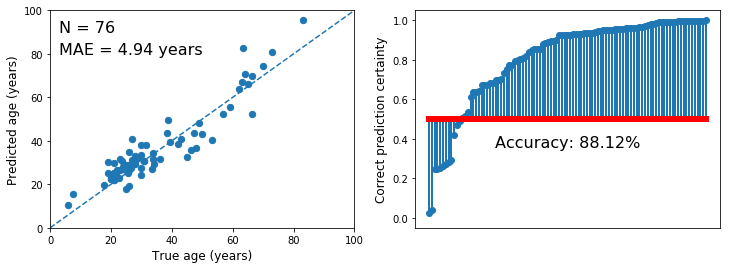


Females
Age MAE: 4.744731929366653
Sex accuracy: 0.9494949494949495


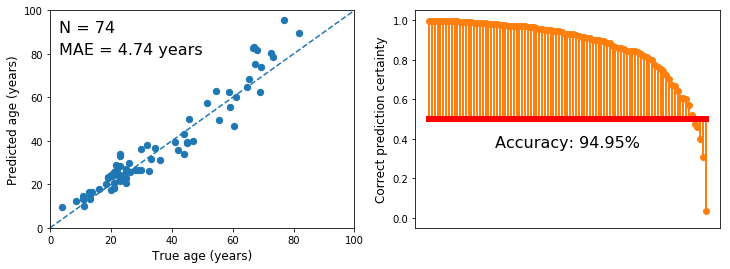


Under 40 years old
Age MAE: 3.8039786032134417
Sex accuracy: 0.8921568627450981


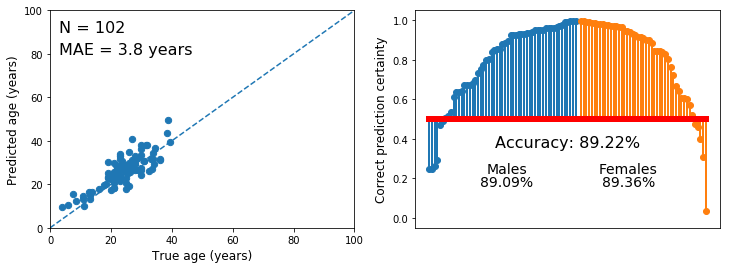


Over 40 years old
Age MAE: 7.050797061920165
Sex accuracy: 0.9791666666666666


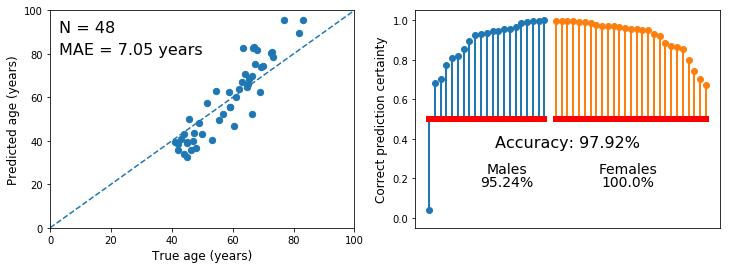


Males under 40
Age MAE: 4.1380863342285155
Sex accuracy: 0.8909090909090909


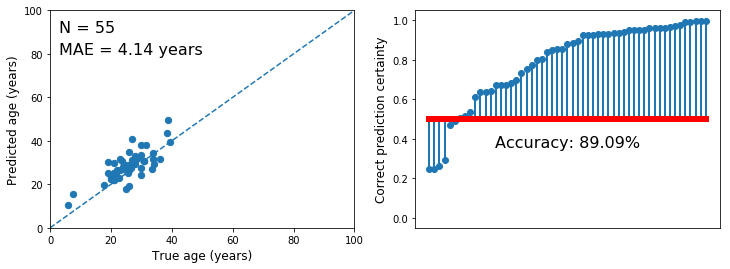


Males over 40
Age MAE: 7.035198349725634
Sex accuracy: 0.9523809523809523


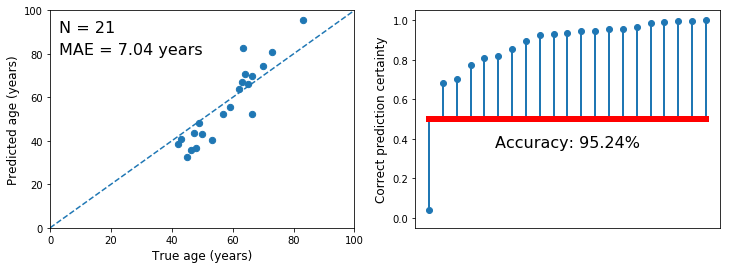


Females under 40
Age MAE: 3.413001471174525
Sex accuracy: 0.8936170212765957


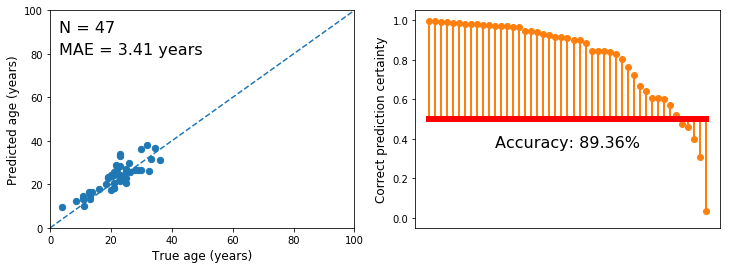


Females over 40
Age MAE: 7.062929393627024
Sex accuracy: 1.0


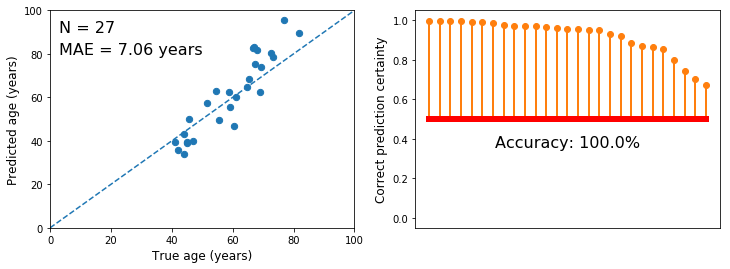

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4b0daadd8>,
       dtype=object))

In [221]:
subset = {'Males':m, 'Females': f,
          'Under 40 years old':u40, 'Over 40 years old':o40,
          'Males under 40': mu40, 'Males over 40': mo40,
          'Females under 40': fu40, 'Females over 40': fo40}
plot_results(subset)

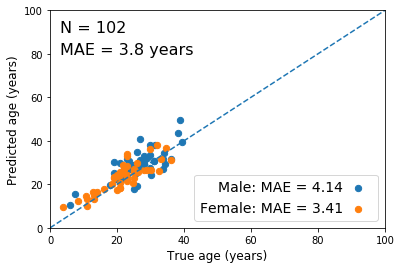

In [257]:
fig,ax = scatter_age(u40, by_sex=True)
fig.savefig('under_40_age.pdf')

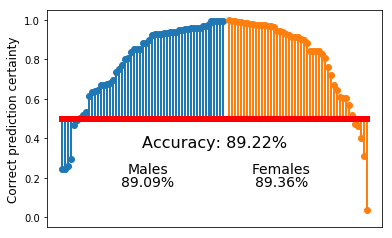

In [258]:
fig,ax = stem_sex(u40)
fig.savefig('under_40_sex.pdf')

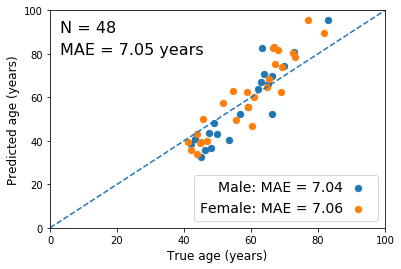

In [259]:
fig,ax = scatter_age(o40, by_sex=True)
fig.savefig('over_40_age.pdf')

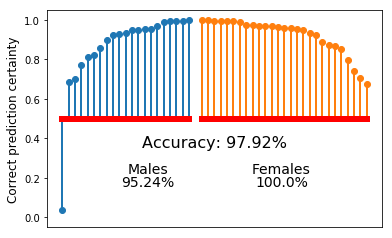

In [260]:
fig,ax = stem_sex(o40)
fig.savefig('over_40_sex.pdf')

In [219]:
plt.rcParams['figure.figsize'] = [6,4]

## Dataset results

In [261]:
ixi = results['IXI_test']
openfmri = results['openfmri_test']
oasis = results['OASIS_test']

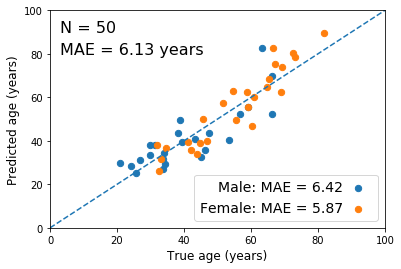

In [267]:
fig,ax = scatter_age(ixi, by_sex=True)
fig.savefig('ixi_age.pdf')

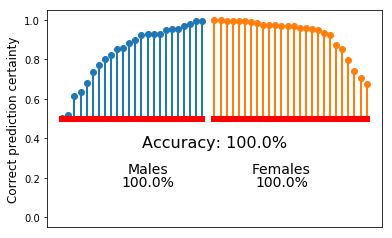

In [268]:
fig,ax = stem_sex(ixi)
fig.savefig('ixi_sex.pdf')

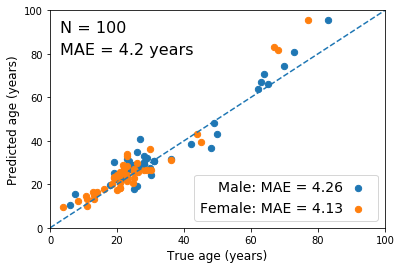

In [264]:
fig,ax = scatter_age(openfmri, by_sex=True)
fig.savefig('openfmri_age.pdf')

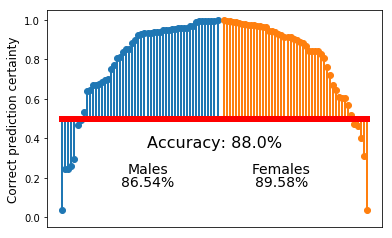

In [265]:
fig,ax = stem_sex(openfmri)
fig.savefig('openfmri_sex.pdf')

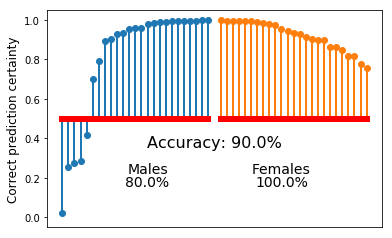

In [266]:
fig,ax = stem_sex(oasis)
fig.savefig('oasis_sex.pdf')